In [1]:
# загружаем необходимые библиотеки
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import warnings

warnings.filterwarnings("ignore")

np.random.seed(1)

%matplotlib inline
# загружаем датафрейм
df = pd.read_csv("discountuplift.csv", sep="\t")
df

,recency,history,used_discount,used_bogo,is_referral,treatment,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web,proba_CN,proba_CR,proba_TN,proba_TR,uplift_score,target_class
0,3,977.51,1,1,1,0,0,0,1,0,0,1,0.476095,0.159710,0.280660,0.083534,-0.043654,0
1,4,391.10,1,0,0,0,1,0,0,1,0,0,0.443035,0.087289,0.285081,0.184594,0.456858,0
2,7,72.37,1,0,1,1,0,0,1,0,0,1,0.514386,0.015488,0.429174,0.040952,0.115756,2
3,10,67.40,1,0,0,1,0,0,1,0,0,1,0.386800,0.125233,0.415839,0.072128,-0.193534,2
4,2,45.68,1,0,1,1,0,0,1,0,1,0,0.517491,0.022507,0.412372,0.047630,0.123726,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12779,5,104.04,1,0,1,0,0,0,1,0,1,0,0.443421,0.063945,0.450813,0.041821,-0.082280,0
12780,3,558.27,1,0,1,1,0,1,0,0,0,1,0.689539,0.027868,0.224104,0.058488,0.336249,2
12781,11,211.30,1,0,0,0,1,0,0,0,0,1,0.421402,0.076274,0.396279,0.106045,0.115697,0
12782,7,335.62,1,0,1,0,0,1,0,0,0,1,0.531513,0.019835,0.381351,0.067301,0.228063,0


In [3]:
# Задание 1 из 4

# Первое, что нужно сделать, — явно выделить колонки с целевой переменной, факторами и целевым воздействием. Напомним значения целевой переменной:
# 0 — контрольная выборка, не купили товар ($y_c=0$);
# 1 — контрольная выборка, купили товар ($y_c=1$);
# 2 — выборка с воздействием (скидка), не купили товар ($y_t=0$);
# 3 — выборка с воздействием (скидка), купили товар ($y_t=1$).

# Преобразуйте исходный датафрейм:
#     добавьте колонку old target  — колонка, которая принимает значение 1, если была покупка, и 0 в противном случае;
#     выделим колонки с факторами и колонку с фактом «целевого воздействия» — выдачи скидки.
df["old_target"] = 0
df["old_target"][df.target_class == 1] = 1
df["old_target"][df.target_class == 3] = 1

feature_cols = [
    "recency",
    "history",
    "used_discount",
    "used_bogo",
    "is_referral",
    "zip_code_Rural",
    "zip_code_Surburban",
    "zip_code_Urban",
    "channel_Multichannel",
    "channel_Phone",
    "channel_Web",
]

target_col = "old_target"
treatment_col = "treatment"
df["old_target"].value_counts()

# Вы видите явный дисбаланс. Это, в общем-то, ожидаемо, так как покупка — гораздо менее частотное событие,
# чем показ или просмотр товара. С этим придётся работать.

old_target
0    10906
1     1878
Name: count, dtype: int64

In [10]:
# Задание 2 из 4
# Теперь разбейте выборку на тренировочную и тестовую.
# Условия: random_state=1, размер тестовой выборки — 25%,
# разбиение стратифицированное по колонке с фактом целевого воздействия и с целевой переменной.

from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(
    df, test_size=0.25, random_state=1, stratify=df[[treatment_col, target_col]]
)
df_train

,recency,history,used_discount,used_bogo,is_referral,treatment,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web,proba_CN,proba_CR,proba_TN,proba_TR,uplift_score,target_class,old_target
2052,12,42.76,1,0,1,0,0,1,0,0,1,0,0.477596,0.002233,0.492098,0.028073,0.098630,0,0
9188,3,236.74,1,1,0,0,1,0,0,0,1,0,0.338212,0.149336,0.319221,0.193231,0.141542,1,1
6079,4,46.65,1,0,1,1,0,0,1,0,0,1,0.430861,0.026719,0.436040,0.106380,0.275457,2,0
9711,1,349.65,1,0,0,0,1,0,0,0,0,1,0.421712,0.128117,0.272425,0.177745,0.323655,1,1
11499,9,155.39,0,1,1,0,0,1,0,0,0,1,0.491633,0.014481,0.447632,0.046254,0.130083,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8684,5,32.08,0,1,1,1,0,1,0,0,1,0,0.417015,0.030215,0.506889,0.045882,0.030887,2,0
1494,3,215.08,0,1,1,1,1,0,0,0,0,1,0.430424,0.083295,0.358919,0.127361,0.199535,2,0
11809,9,29.99,1,0,1,0,0,1,0,0,0,1,0.473600,0.015479,0.437820,0.073101,0.222857,0,0
518,6,48.30,1,0,1,1,0,0,1,0,0,1,0.386906,0.009045,0.526550,0.077498,0.210908,2,0


In [12]:
sum(df_train["old_target"] == 1) / len(df_train)

0.14685022945348353

In [13]:
# Задание 3 из 4
# Теперь обучите S-learner (в данном случае это логистическая регрессия).

from sklearn.linear_model import LogisticRegression

s_learner = LogisticRegression(
    random_state=1
)  # создайте логистическую регрессию с random_state=1
s_learner.fit(X=df_train[feature_cols + [treatment_col]], y=df_train[target_col])

# посчитайте intercept
s_learner.intercept_

array([-1.15345898])

In [14]:
# Задание 4 из 4
# Финишная прямая! Измерьте качество модели при помощи Qini Score.
# В прекоде к этому заданию мы затронем все шаги — в будущем же вы сможете писать боее короткий код инференса модели.

# предскажем вероятность покупки, если скидка есть
df_test[treatment_col] = 1
df_test["yes_treatment"] = s_learner.predict_proba(
    df_test[feature_cols + [treatment_col]]
)[:, 1]

# предскажите вероятность покупки, если скидки нет
df_test[treatment_col] = 0
df_test["no_treatment"] = s_learner.predict_proba(
    df_test[feature_cols + [treatment_col]]
)[:, 1]

df_test

,recency,history,used_discount,used_bogo,is_referral,treatment,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,...,channel_Web,proba_CN,proba_CR,proba_TN,proba_TR,uplift_score,target_class,old_target,yes_treatment,no_treatment
8348,9,718.64,1,0,1,0,1,0,0,1,...,0,0.554067,0.023504,0.352675,0.069754,0.248863,2,0,0.163836,0.100078
6137,4,135.53,0,1,0,0,0,0,1,0,...,0,0.509346,0.067572,0.290056,0.133027,0.394595,2,0,0.169592,0.103872
5198,4,98.09,0,1,0,0,0,1,0,0,...,0,0.419013,0.023046,0.449408,0.108532,0.284777,2,0,0.171729,0.105286
11830,4,102.07,0,1,1,0,1,0,0,0,...,0,0.414532,0.074022,0.403786,0.107660,0.117977,2,0,0.142589,0.086246
7148,4,929.49,0,1,1,0,0,0,1,0,...,0,0.476988,0.036499,0.440797,0.045717,0.045775,2,0,0.165916,0.101446
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7008,5,55.83,1,0,0,0,1,0,0,0,...,1,0.266035,0.078418,0.502782,0.152766,0.010753,0,0,0.303947,0.198614
1445,5,337.42,1,1,0,0,0,0,1,1,...,0,0.395237,0.047588,0.332330,0.224845,0.592160,0,0,0.250564,0.159493
5369,10,162.84,1,0,0,0,0,0,1,0,...,0,0.501184,0.040953,0.397356,0.060507,0.113223,0,0,0.121825,0.072988
6318,9,29.99,0,1,1,0,0,1,0,0,...,1,0.454410,0.023769,0.457090,0.064731,0.148680,0,0,0.103297,0.061369


In [15]:
# реализуем подсчёт Qini Score:
def qini_df(df):
    # отранжируем выборку по значению uplift в порядке убывания
    ranked = df.sort_values("uplift_score", ascending=False)

    N_c = sum(ranked["target_class"] <= 1)
    N_t = sum(ranked["target_class"] >= 2)

    # посчитаем в отсортированном датафрейме основные показатели,
    # которые используются при расчёте Qini Score
    ranked["n_c1"] = 0
    ranked["n_t1"] = 0
    ranked.loc[ranked.target_class == 1, "n_c1"] = 1
    ranked.loc[ranked.target_class == 3, "n_t1"] = 1
    ranked["n_c1/nc"] = ranked.n_c1.cumsum() / N_c
    ranked["n_t1/nt"] = ranked.n_t1.cumsum() / N_t

    # посчитаем Qini-кривую и случайную прямую под ней
    ranked["uplift"] = round(ranked["n_t1/nt"] - ranked["n_c1/nc"], 5)
    # добавим случайную кривую
    ranked["random_uplift"] = round(
        ranked["uplift_score"].rank(pct=True, ascending=False)
        * ranked["uplift"].iloc[-1],
        5,
    )

    ranked["n"] = ranked["uplift_score"].rank(pct=True, ascending=False)
    # немного кода для визуализации
    plt.plot(ranked["n"], ranked["uplift"], color="r")
    plt.plot(ranked["n"], ranked["random_uplift"], color="b")
    plt.show()

    return (ranked["uplift"] - ranked["random_uplift"]).sum()

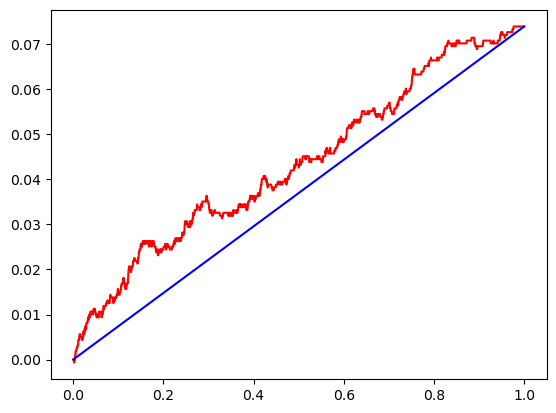

20.995829999999998

In [16]:
uplift_vals = (
    df_test["yes_treatment"] - df_test["no_treatment"]
)  # посчитаем uplift на объектах тестовой выборки
df_test["uplift_score"] = uplift_vals

# посчитаем Qini Score по нашему датасету
qini_df(df_test)

In [17]:
df_test

,recency,history,used_discount,used_bogo,is_referral,treatment,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,...,channel_Web,proba_CN,proba_CR,proba_TN,proba_TR,uplift_score,target_class,old_target,yes_treatment,no_treatment
8348,9,718.64,1,0,1,0,1,0,0,1,...,0,0.554067,0.023504,0.352675,0.069754,0.063759,2,0,0.163836,0.100078
6137,4,135.53,0,1,0,0,0,0,1,0,...,0,0.509346,0.067572,0.290056,0.133027,0.065720,2,0,0.169592,0.103872
5198,4,98.09,0,1,0,0,0,1,0,0,...,0,0.419013,0.023046,0.449408,0.108532,0.066443,2,0,0.171729,0.105286
11830,4,102.07,0,1,1,0,1,0,0,0,...,0,0.414532,0.074022,0.403786,0.107660,0.056343,2,0,0.142589,0.086246
7148,4,929.49,0,1,1,0,0,0,1,0,...,0,0.476988,0.036499,0.440797,0.045717,0.064470,2,0,0.165916,0.101446
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7008,5,55.83,1,0,0,0,1,0,0,0,...,1,0.266035,0.078418,0.502782,0.152766,0.105332,0,0,0.303947,0.198614
1445,5,337.42,1,1,0,0,0,0,1,1,...,0,0.395237,0.047588,0.332330,0.224845,0.091072,0,0,0.250564,0.159493
5369,10,162.84,1,0,0,0,0,0,1,0,...,0,0.501184,0.040953,0.397356,0.060507,0.048836,0,0,0.121825,0.072988
6318,9,29.99,0,1,1,0,0,1,0,0,...,1,0.454410,0.023769,0.457090,0.064731,0.041928,0,0,0.103297,0.061369
